# Milestone 1:  Project Plan, describe datasets, joins, tasks, and metrics

In [2]:
!ls

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [1]:
!jupyter nbconvert --to latex "M1.ipynb"

[NbConvertApp] Converting notebook M1.ipynb to latex
Traceback (most recent call last):
  File "C:\Users\10648\miniconda3\envs\spark\lib\site-packages\nbformat\reader.py", line 19, in parse_json
    nb_dict = json.loads(s, **kwargs)
  File "C:\Users\10648\miniconda3\envs\spark\lib\json\__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "C:\Users\10648\miniconda3\envs\spark\lib\json\decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "C:\Users\10648\miniconda3\envs\spark\lib\json\decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\10648\miniconda3\envs\spark\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\10648\

## DELIVERABLES:
### Data Dictionary
| Feature | Description | Source | Data Type |
|---------|-------------|--------|-----------|
| Symbol | Stock ticker symbol | Original | String |
| Date | Trading date | CSV | Date |
| Low | Lowest price of the day | CSV | Float |
| Open | Opening price | CSV | Float |
| Volume | Number of shares traded | CSV | Integer |
| High | Highest price of the day | CSV | Float |
| Close | Closing price | CSV | Float |
| Adjusted_Close | Close price adjusted for splits and dividends | CSV | Float |
| currency | Trading currency | JSON | String |
| exchange | Stock exchange | JSON | String |
| instrumentType | Type of financial instrument | JSON | String |
| firstTradeDate | Unix timestamp of first trading date | JSON | Integer |
| regularMarketPrice | Latest regular market price | JSON | Float |
| chartPreviousClose | Previous closing price from chart | JSON | Float |
| timezone | Trading timezone | JSON | String |
| tradingPeriods | Trading session information | JSON | Array |
| PrevClose | Previous day's closing price | Derived | Float |
| Return | Daily price return percentage | Derived | Float |
| LogReturn | Natural log of daily return | Derived | Float |
| MA7 | 7-day moving average of Close | Derived | Float |
| MA30 | 30-day moving average of Close | Derived | Float |
| MA90 | 90-day moving average of Close | Derived | Float |
| Close_MA7_Ratio | Ratio of Close to 7-day MA | Derived | Float |
| Close_MA30_Ratio | Ratio of Close to 30-day MA | Derived | Float |
| MA7_MA30_Ratio | Ratio of 7-day MA to 30-day MA | Derived | Float |
| STD7 | 7-day standard deviation of Close | Derived | Float |
| STD30 | 30-day standard deviation of Close | Derived | Float |
| VolatilityRatio | Ratio of 7-day to 30-day volatility | Derived | Float |
| HighLowRange | Daily price range (High - Low) | Derived | Float |
| VolumeDelta | Change in volume from previous day | Derived | Float |
| VolumeMA7 | 7-day moving average of Volume | Derived | Float |
| VolumeMA30 | 30-day moving average of Volume | Derived | Float |
| RelativeVolume | Volume relative to 30-day average | Derived | Float |
| MoneyFlow | Volume (Close - Open) | Derived | Float |
| RSI | 14-day Relative Strength Index | Derived | Float |
| Target_Return_1d | 1-day future return | Target | Float |
| Target_Return_5d | 5-day future return | Target | Float |
| Target_Return_10d | 10-day future return | Target | Float |
| Target_Return_21d | 21-day future return | Target | Float |
| Target_Direction_1d | 1-day price direction (1=up, 0=down) | Target | Binary |
| Target_Direction_5d | 5-day price direction | Target | Binary |
| Target_Direction_10d | 10-day price direction | Target | Binary |
| Target_Direction_21d | 21-day price direction | Target | Binary |
| Target_Volatility_5d | Volatility over next 5 days | Target | Float |
| Target_ExtMove2pct_1d | 1-day extreme move (>2%) | Target | Binary |
| Target_ExtMove5pct_5d | 5-day extreme move (>5%) | Target | Binary |

## Project notebook

Preprocess

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import os
import glob
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, lead, lag, avg, stddev, min, max
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType, IntegerType
from pyspark.sql.functions import sqrt, avg, lead, col, expr, to_date, year, mean, log, row_number
from pyspark.sql.window import Window

## 1. Explain data (i.e.., simple exploratory analysis of various fields, such as the semantic as well the intrinsic meaning of ranges, null values, categorical/numerical, mean/std.dev to normalize and/or scale inputs). Identify any missing or corrupt (i.e., outlier) data.

In [2]:
# Initialize PySpark session
spark = SparkSession.builder \
    .appName("Stock Price Forecast") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Define paths to data directories
csv_path = "data/stock_market_data/forbes2000/csv/"
json_path = "data/stock_market_data/forbes2000/json/"

# Get a list of all available stock files
csv_files = glob.glob(os.path.join(csv_path, "*.csv"))
json_files = glob.glob(os.path.join(json_path, "*.json"))

print(f"Found {len(csv_files)} CSV files and {len(json_files)} JSON files")

# Display some sample stocks
print("Sample stocks:")
print([os.path.basename(file).split('.')[0] for file in csv_files[:10]])

25/03/16 11:18:14 WARN Utils: Your hostname, Xuhuis-MacBook-Pro-105.local resolves to a loopback address: 127.0.0.1; using 172.16.96.118 instead (on interface en0)
25/03/16 11:18:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/16 11:18:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Found 1076 CSV files and 1170 JSON files
Sample stocks:
['CSCO', 'CSUAY', 'MQBKY', 'AIPUY', 'ZURVY', 'PWCDF', 'SMTUF', 'BCMXY', 'JMPLY', 'KOTMY']


#### Data Structure Analysis
CSV Data Structure

The CSV files contain daily trading data with these columns:

Date: Trading date

Low: Lowest price of the day

Open: Opening price

Volume: Number of shares traded

High: Highest price of the day

Close: Closing price

Adjusted Close: Closing price adjusted for splits and dividends

JSON Data Structure

The JSON files contain more detailed information:

Meta data: Currency, symbol, exchange, instrument type, etc.

Trading periods information

More granular timestamp series

Additional price history details

In [3]:
# Define schema for CSV files to ensure consistent data types
csv_schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Open", DoubleType(), True),
    StructField("Volume", IntegerType(), True),
    StructField("High", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adjusted_Close", DoubleType(), True)
])

# Create an empty DataFrame to store the combined CSV data
combined_df = None

# Process a sample of CSV files (e.g., first 20 files) for initial exploration
for file in csv_files[:20]:
    ticker = os.path.basename(file).split('.')[0]
    
    # Read the CSV file into a Spark DataFrame
    current_df = spark.read.csv(file, header=True, schema=csv_schema)
    
    # Add ticker symbol as a column
    current_df = current_df.withColumn("Symbol", lit(ticker))
    
    # Convert date string to date type
    current_df = current_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
    
    # Append to the combined DataFrame
    if combined_df is None:
        combined_df = current_df
    else:
        combined_df = combined_df.union(current_df)

# Show summary of the combined data
print(f"Combined CSV data contains {combined_df.count()} rows for {len(combined_df.select('Symbol').distinct().collect())} stocks")
combined_df.printSchema()
combined_df.show(5)

# Analyze JSON structure from one file to understand available fields
sample_json_file = json_files[0]
with open(sample_json_file, 'r') as f:
    sample_json = json.load(f)

# Extract metadata fields from JSON
meta = sample_json['chart']['result'][0]['meta']
print("\nJSON Metadata Fields:")
for key, value in meta.items():
    if not isinstance(value, dict):
        print(f"- {key}: {value}")

# Look at available indicator types in JSON
indicators = sample_json['chart']['result'][0]['indicators']
print("\nAvailable indicators in JSON:")
for indicator_type, values in indicators.items():
    print(f"- {indicator_type}: {len(values[0]) if len(values) > 0 else 0} fields")

Combined CSV data contains 79969 rows for 20 stocks
root
 |-- Date: date (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- High: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adjusted_Close: double (nullable = true)
 |-- Symbol: string (nullable = false)



25/03/16 11:18:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSCO.csv


+----------+-------------------+----+---------+-------------------+-------------------+-------------------+------+
|      Date|                Low|Open|   Volume|               High|              Close|     Adjusted_Close|Symbol|
+----------+-------------------+----+---------+-------------------+-------------------+-------------------+------+
|1990-02-16|0.07378499954938889| 0.0|940636800|0.07986100018024445|0.07725699990987778|0.05486249923706055|  CSCO|
|1990-02-20|0.07465299963951111| 0.0|151862400|0.07986100018024445|0.07986100018024445|0.05671168491244316|  CSCO|
|1990-02-21|0.07552099972963333| 0.0| 70531200|0.07899300009012222|           0.078125|0.05547890439629555|  CSCO|
|1990-02-22|0.07899300009012222| 0.0| 45216000|0.08159700036048889|0.07899300009012222|0.05609529837965965|  CSCO|
|1990-02-23|           0.078125| 0.0| 44697600|0.07986100018024445|0.07855899631977081|0.05578707531094551|  CSCO|
+----------+-------------------+----+---------+-------------------+-------------

25/03/16 11:18:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSCO.csv
25/03/16 11:18:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: Date, Low, Open, Volume, High, Close, Adjusted Close
 Schema: Date, Low, Open, Volume, High, Close, Adjusted_Close
Expected: Adjusted_Close but found: Adjusted Close
CSV file: file:///Users/xuhuizhan/homework/BigData/Final_project/data/stock_market_data/forbes2000/csv/CSUAY.csv


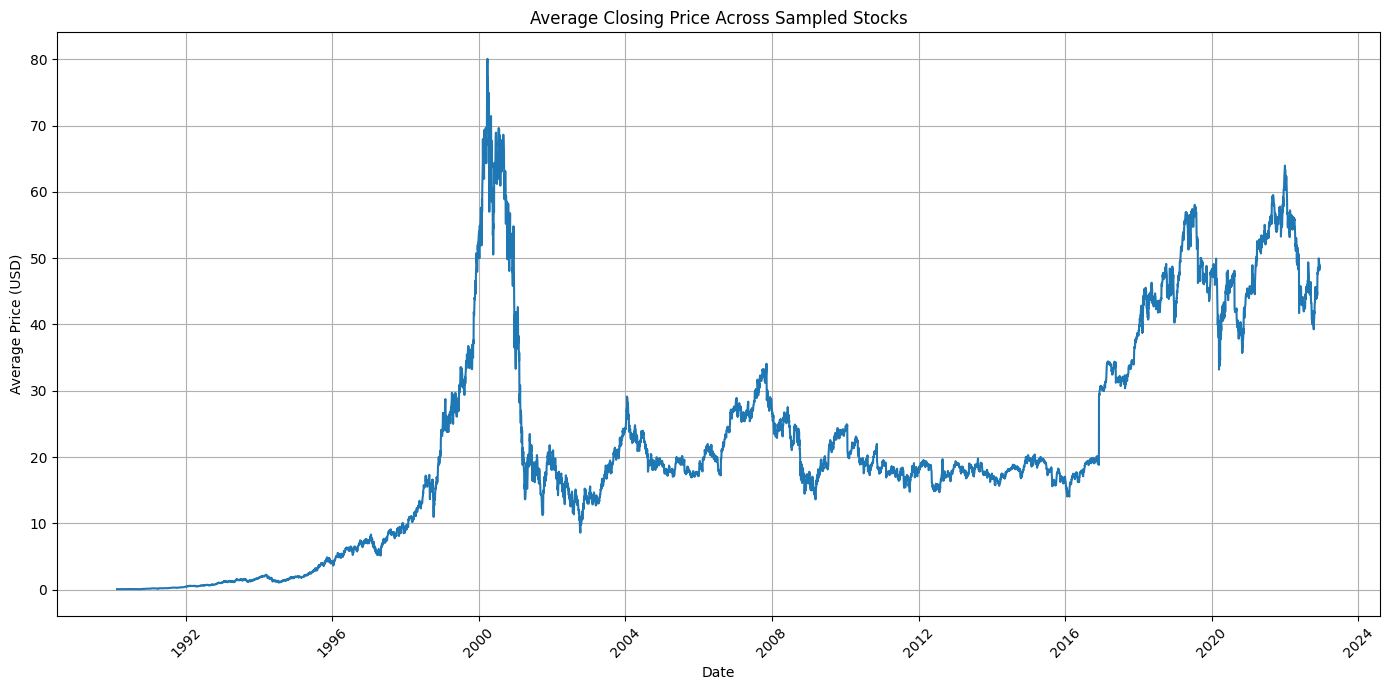

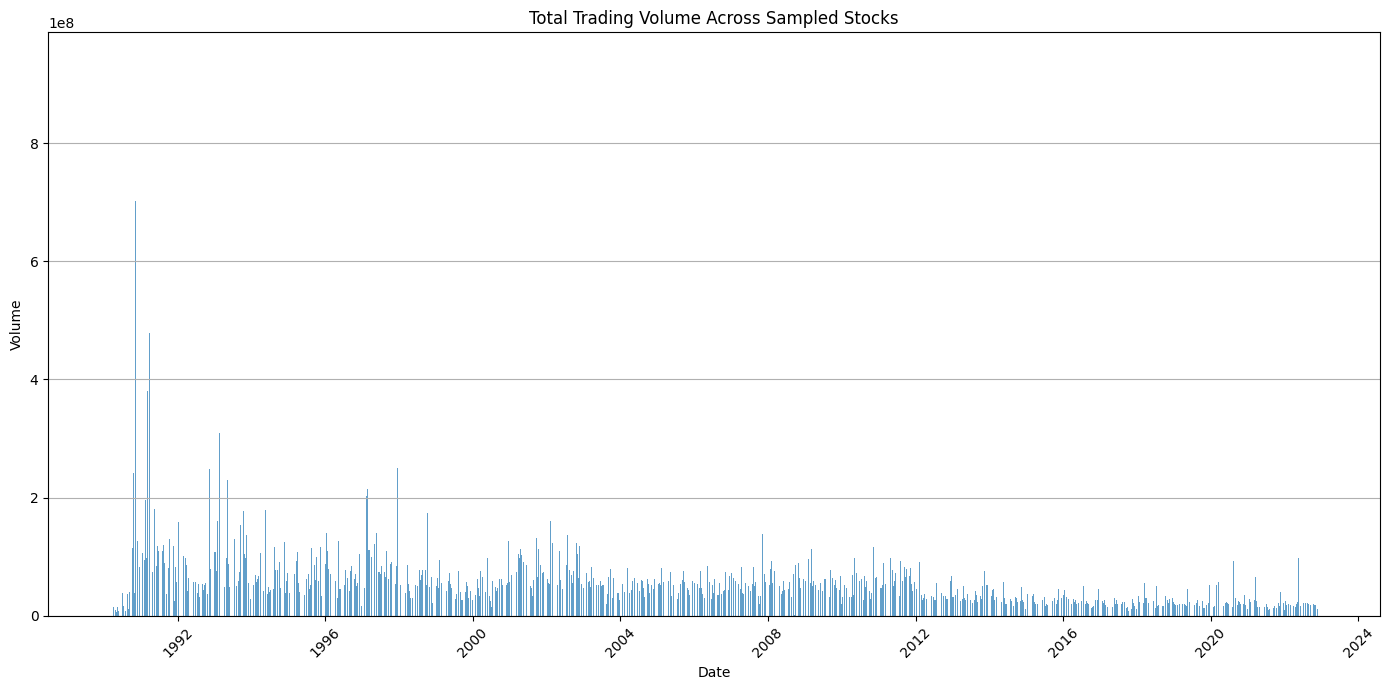

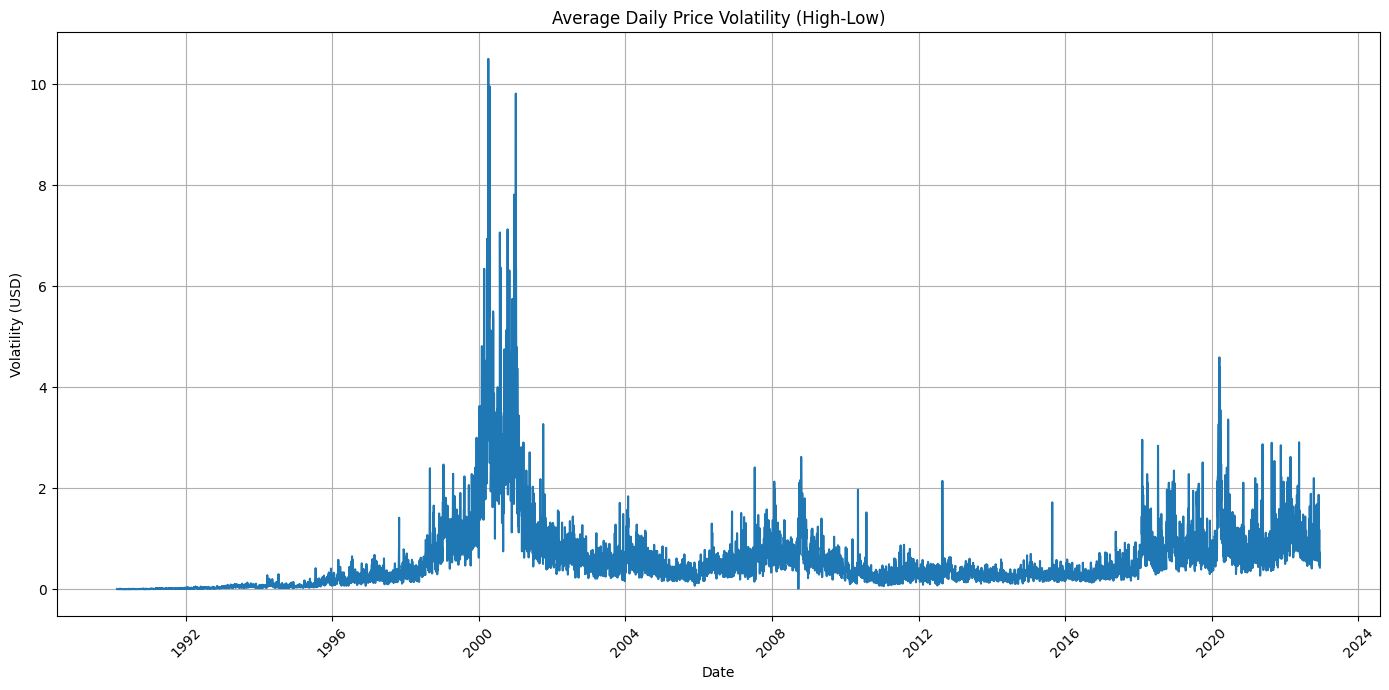

In [4]:
# Convert to Pandas for visualization (use a sample for efficiency)
pandas_df = combined_df.limit(10000).toPandas()

# Group by date and calculate market-wide metrics
market_df = pandas_df.groupby('Date').agg({
    'Close': 'mean',
    'Volume': 'sum',
    'High': 'mean',
    'Low': 'mean'
}).reset_index()

# Plot market-wide closing price trend
plt.figure(figsize=(14, 7))
plt.plot(market_df['Date'], market_df['Close'])
plt.title('Average Closing Price Across Sampled Stocks')
plt.xlabel('Date')
plt.ylabel('Average Price (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot trading volume trend
plt.figure(figsize=(14, 7))
plt.bar(market_df['Date'], market_df['Volume'], alpha=0.7)
plt.title('Total Trading Volume Across Sampled Stocks')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize price volatility over time
market_df['Volatility'] = market_df['High'] - market_df['Low']
plt.figure(figsize=(14, 7))
plt.plot(market_df['Date'], market_df['Volatility'])
plt.title('Average Daily Price Volatility (High-Low)')
plt.xlabel('Date')
plt.ylabel('Volatility (USD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Calculate returns for each stock
window_spec = Window.partitionBy("Symbol").orderBy("Date")
combined_df = combined_df.withColumn("PrevClose", lag("Close", 1).over(window_spec))
combined_df = combined_df.withColumn("DailyReturn", (col("Close") - col("PrevClose")) / col("PrevClose"))

# Summary statistics of returns by stock
returns_by_stock = combined_df.groupBy("Symbol").agg(
    avg(col("DailyReturn")).alias("AvgReturn"),
    stddev(col("DailyReturn")).alias("Volatility"),
    count("*").alias("TradingDays")
)

# Filter for stocks with sufficient data
active_stocks = returns_by_stock.filter(col("TradingDays") > 500)

# Show top stocks by average return
print("Top 10 Stocks by Average Return:")
active_stocks.orderBy(col("AvgReturn").desc()).show(10)

# Show top stocks by volatility
print("Top 10 Stocks by Volatility:")
active_stocks.orderBy(col("Volatility").desc()).show(10)

Top 10 Stocks by Average Return:


+------+--------------------+--------------------+-----------+
|Symbol|           AvgReturn|          Volatility|TradingDays|
+------+--------------------+--------------------+-----------+
|  AUTR|0.004226934351660896| 0.12415432977666538|       2994|
| AIPUY|0.001395491989984...|0.036751769256370824|       2555|
|  ISRG|0.001356723705433...|0.031622103192064835|       5659|
|  CSCO|0.001101145212940...| 0.02539036285241598|       8269|
|   UAL|9.208234591147626E-4| 0.04181226274169283|       4243|
|  TROW| 8.23801362467354E-4|0.023837998444357102|       9251|
| SZLMY|7.389298917427634E-4|0.019834647211186798|       3422|
|  PBNK|6.140578505195129E-4| 0.03165189097679212|       3934|
| MQBKY|5.961209532660768E-4|0.028106562247908983|       4129|
| ZURVY|4.545994492009156E-4|0.018491849351474646|       4916|
+------+--------------------+--------------------+-----------+
only showing top 10 rows

Top 10 Stocks by Volatility:
+------+--------------------+--------------------+-----------+


In [6]:
# Function to detect outliers using IQR method
def detect_outliers(df, column_name):
    # Calculate quartiles for each stock
    quartiles = df.groupBy("Symbol").agg(
        expr(f"percentile({column_name}, 0.25)").alias("Q1"),
        expr(f"percentile({column_name}, 0.75)").alias("Q3")
    )
    
    # Calculate IQR and bounds
    quartiles = quartiles.withColumn("IQR", col("Q3") - col("Q1"))
    quartiles = quartiles.withColumn("LowerBound", col("Q1") - 1.5 * col("IQR"))
    quartiles = quartiles.withColumn("UpperBound", col("Q3") + 1.5 * col("IQR"))
    
    # Join back to main dataframe
    df_with_bounds = df.join(quartiles.select("Symbol", "LowerBound", "UpperBound"), "Symbol")
    
    # Flag outliers
    outliers = df_with_bounds.filter(
        (col(column_name) < col("LowerBound")) | 
        (col(column_name) > col("UpperBound"))
    )
    
    return outliers

# Detect outliers in volume
volume_outliers = detect_outliers(combined_df, "Volume")
print(f"Volume outliers: {volume_outliers.count()} ({volume_outliers.count()/combined_df.count()*100:.2f}%)")

# Detect outliers in daily returns
return_outliers = detect_outliers(combined_df.filter(col("DailyReturn").isNotNull()), "DailyReturn")
print(f"Return outliers: {return_outliers.count()} ({return_outliers.count()/combined_df.filter(col('DailyReturn').isNotNull()).count()*100:.2f}%)")

# Sample some outliers to understand their nature
print("Sample volume outliers:")
volume_outliers.select("Symbol", "Date", "Volume", "LowerBound", "UpperBound").show(10)

print("Sample return outliers:")
return_outliers.select("Symbol", "Date", "DailyReturn", "LowerBound", "UpperBound").show(10)

Volume outliers: 7554 (9.45%)


Return outliers: 8413 (10.55%)
Sample volume outliers:
+------+----------+---------+-----------+-----------+
|Symbol|      Date|   Volume| LowerBound| UpperBound|
+------+----------+---------+-----------+-----------+
|  CSCO|2014-02-13|153739400|-2.880675E7|1.2281445E8|
|  CSCO|2013-11-14|243255400|-2.880675E7|1.2281445E8|
|  CSCO|2013-08-15|130110100|-2.880675E7|1.2281445E8|
|  CSCO|2013-05-16|201626500|-2.880675E7|1.2281445E8|
|  CSCO|2012-08-16|152184100|-2.880675E7|1.2281445E8|
|  CSCO|2012-05-10|198450600|-2.880675E7|1.2281445E8|
|  CSCO|2012-02-09|131157200|-2.880675E7|1.2281445E8|
|  CSCO|2011-11-10|148101900|-2.880675E7|1.2281445E8|
|  CSCO|2011-08-11|286920000|-2.880675E7|1.2281445E8|
|  CSCO|2011-08-10|146477100|-2.880675E7|1.2281445E8|
+------+----------+---------+-----------+-----------+
only showing top 10 rows

Sample return outliers:
+------+----------+--------------------+----------+----------+
|Symbol|      Date|         DailyReturn|LowerBound|UpperBound|
+------+-----

JSON Data Structure Analysis

In [7]:
# Path to JSON files
json_path = "data/stock_market_data/forbes2000/json/"
json_files = glob.glob(os.path.join(json_path, "*.json"))

# Sample a few JSON files to understand their structure
sample_json_files = json_files[:5]
json_structures = []

for file in sample_json_files:
    ticker = os.path.basename(file).split('.')[0]
    with open(file, 'r') as f:
        data = json.load(f)
    
    # Extract metadata
    try:
        meta = data['chart']['result'][0]['meta']
        indicators = data['chart']['result'][0]['indicators']
        timestamps = data['chart']['result'][0]['timestamp']
        
        # Count available data points
        quote_length = len(indicators['quote'][0]['close']) if 'quote' in indicators else 0
        
        # Extract available indicator types
        available_indicators = list(indicators.keys())
        
        json_structures.append({
            'Symbol': ticker,
            'MetadataFields': list(meta.keys()),
            'AvailableIndicators': available_indicators,
            'TimeseriesLength': len(timestamps),
            'QuoteDataPoints': quote_length
        })
    except (KeyError, IndexError) as e:
        print(f"Error analyzing {file}: {e}")

# Convert to DataFrame for analysis
json_structure_df = pd.DataFrame(json_structures)
print("JSON Structure Analysis:")
print(json_structure_df)

# Analyze metadata fields across files
all_metadata_fields = set()
for fields in json_structure_df['MetadataFields']:
    all_metadata_fields.update(fields)
    
print(f"\nCommon metadata fields across JSON files: {all_metadata_fields}")

# Analyze indicator types across files
all_indicators = set()
for indicators in json_structure_df['AvailableIndicators']:
    all_indicators.update(indicators)
    
print(f"\nAvailable indicator types in JSON files: {all_indicators}")

JSON Structure Analysis:
  Symbol                                     MetadataFields  \
0  FOJCY  [currency, symbol, exchangeName, instrumentTyp...   
1      T  [currency, symbol, exchangeName, instrumentTyp...   
2    PHM  [currency, symbol, exchangeName, instrumentTyp...   
3    ADM  [currency, symbol, exchangeName, instrumentTyp...   
4    RNA  [currency, symbol, exchangeName, instrumentTyp...   

  AvailableIndicators  TimeseriesLength  QuoteDataPoints  
0   [quote, adjclose]              3259             3259  
1   [quote, adjclose]              9846             9846  
2   [quote, adjclose]             10778            10778  
3   [quote, adjclose]             10778            10778  
4   [quote, adjclose]               631              631  

Common metadata fields across JSON files: {'currentTradingPeriod', 'exchangeName', 'firstTradeDate', 'regularMarketTime', 'regularMarketPrice', 'timezone', 'chartPreviousClose', 'symbol', 'gmtoffset', 'instrumentType', 'exchangeTimezoneName'

Basic statistics for JSON price data:
               Open          High           Low         Close        Volume  \
count  35292.000000  35292.000000  35292.000000  35292.000000  3.529200e+04   
mean      17.153682     17.488223     17.052797     17.273139  7.336812e+06   
std       14.784774     14.825064     14.475348     14.652317  1.410614e+07   
min        0.000000      0.156250      0.140625      0.144531  0.000000e+00   
25%        4.580000      4.625000      4.545612      4.590000  7.729452e+05   
50%       13.804985     13.991539     13.613767     13.809649  2.266462e+06   
75%       26.230000     26.480000     25.915422     26.211502  5.819225e+06   
max       98.709999     98.879997     96.849998     98.220001  3.270974e+08   

           AdjClose  
count  35292.000000  
mean      11.722431  
std       13.449199  
min        0.102742  
25%        2.314733  
50%        6.739854  
75%       17.583542  
max       97.669998  

JSON data density (non-null values):
Symbol      1.

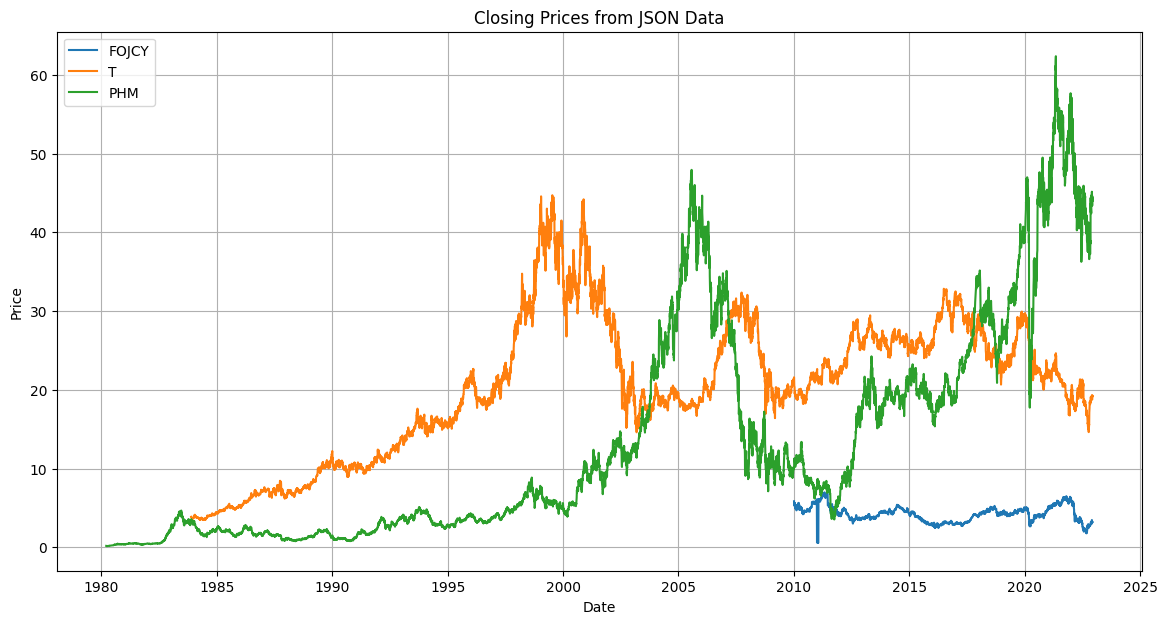

In [8]:
def extract_json_price_data(json_file):
    """Extract detailed price data from JSON file"""
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    try:
        ticker = os.path.basename(json_file).split('.')[0]
        result = data['chart']['result'][0]
        meta = result['meta']
        timestamps = result['timestamp']
        
        # Convert timestamps to dates
        dates = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamps]
        
        # Extract quote data
        quotes = result['indicators']['quote'][0]
        
        # Create DataFrame with detailed price data
        df = pd.DataFrame({
            'Symbol': ticker,
            'Date': dates,
            'Open': quotes.get('open', [None] * len(dates)),
            'High': quotes.get('high', [None] * len(dates)),
            'Low': quotes.get('low', [None] * len(dates)),
            'Close': quotes.get('close', [None] * len(dates)),
            'Volume': quotes.get('volume', [None] * len(dates))
        })
        
        # Add additional indicators if available
        if 'adjclose' in result['indicators']:
            df['AdjClose'] = result['indicators']['adjclose'][0].get('adjclose', [None] * len(dates))
        
        return df
    except (KeyError, IndexError) as e:
        print(f"Error extracting price data from {json_file}: {e}")
        return None

# Extract price data from sample JSON files
json_price_dfs = []
for file in sample_json_files:
    price_df = extract_json_price_data(file)
    if price_df is not None:
        json_price_dfs.append(price_df)

# Combine all price data
combined_json_price_df = pd.concat(json_price_dfs, ignore_index=True)

# Basic statistics for JSON price data
print("Basic statistics for JSON price data:")
print(combined_json_price_df.describe())

# Compare with CSV data density
print("\nJSON data density (non-null values):")
print(combined_json_price_df.count() / len(combined_json_price_df))

# Visualize JSON price data granularity
plt.figure(figsize=(14, 7))
for ticker in combined_json_price_df['Symbol'].unique()[:3]:  # First 3 stocks
    ticker_data = combined_json_price_df[combined_json_price_df['Symbol'] == ticker]
    plt.plot(pd.to_datetime(ticker_data['Date']), ticker_data['Close'], label=ticker)

plt.title('Closing Prices from JSON Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Metadata Analysis:
Unique exchanges: ['PNK' 'NYQ' 'NGM' 'NMS' 'YHD']
Unique currencies: ['USD' None]
Unique instrument types: ['EQUITY' 'MUTUALFUND']


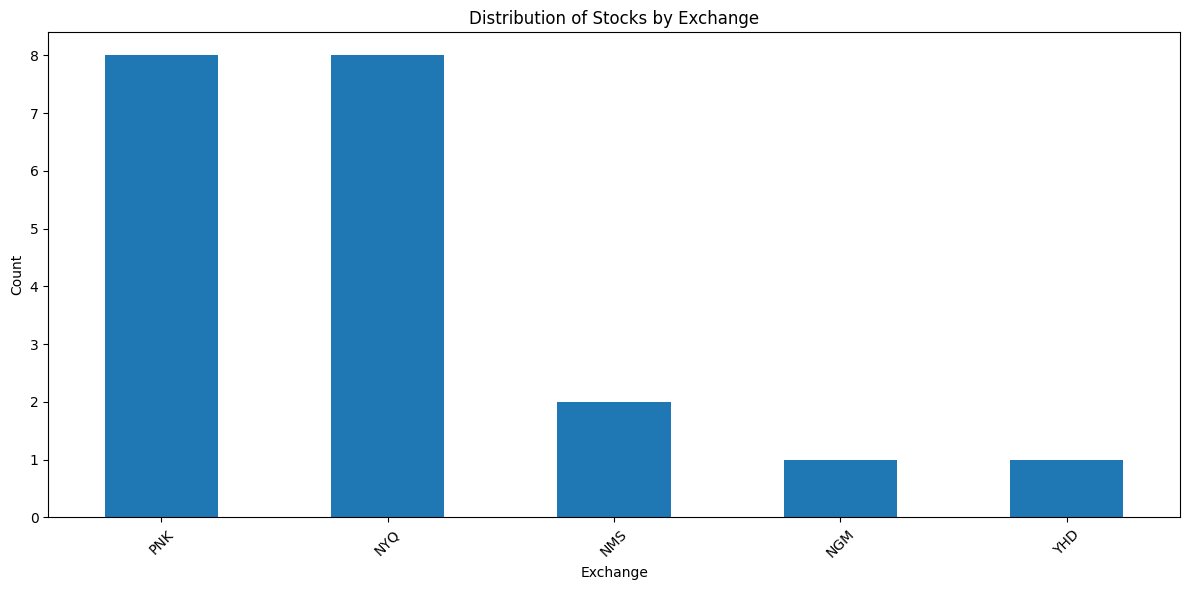

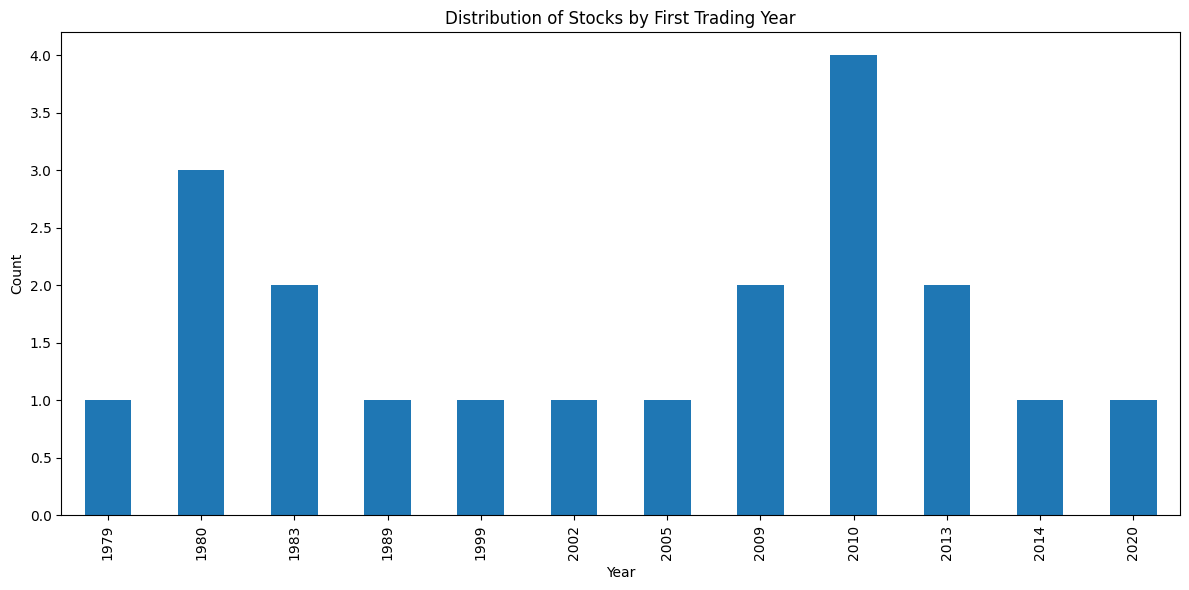

In [9]:
def extract_metadata_features(json_file):
    """Extract valuable metadata features from JSON file"""
    try:
        with open(json_file, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading JSON file {json_file}: {e}")
        return None
    
    try:
        ticker = os.path.basename(json_file).split('.')[0]
        meta = data['chart']['result'][0]['meta']
        
        # Extract valuable metadata fields
        metadata = {
            'Symbol': ticker,
            'Currency': meta.get('currency'),
            'Exchange': meta.get('exchangeName'),
            'InstrumentType': meta.get('instrumentType'),
            'FirstTradeDate': meta.get('firstTradeDate'),
            'RegularMarketPrice': meta.get('regularMarketPrice'),
            'ChartPreviousClose': meta.get('chartPreviousClose'),
            'PriceHint': meta.get('priceHint'),
            'TimeZone': meta.get('timezone')
        }
        
        # Extract any available trading periods
        if 'tradingPeriods' in meta:
            trading_periods = meta['tradingPeriods']
            if trading_periods and len(trading_periods) > 0 and len(trading_periods[0]) > 0:
                period = trading_periods[0][0]
                metadata.update({
                    'TradingStart': period.get('start'),
                    'TradingEnd': period.get('end'),
                    'TradingTimezone': period.get('timezone')
                })
        
        # Extract current trading state if available
        if 'currentTradingPeriod' in meta:
            current = meta['currentTradingPeriod'].get('regular', {})
            metadata.update({
                'CurrentTradingStart': current.get('start'),
                'CurrentTradingEnd': current.get('end')
            })
            
        return metadata
    except (KeyError, IndexError) as e:
        print(f"Error extracting metadata from {json_file}: {e}")
        return None

# Extract metadata from all sample JSON files
metadata_list = []
for file in json_files[:20]:  # Analyze a reasonable sample
    metadata = extract_metadata_features(file)
    if metadata:
        metadata_list.append(metadata)

# Convert to DataFrame for analysis
metadata_df = pd.DataFrame(metadata_list)

# Analyze metadata distributions
print("Metadata Analysis:")
print(f"Unique exchanges: {metadata_df['Exchange'].unique()}")
print(f"Unique currencies: {metadata_df['Currency'].unique()}")
print(f"Unique instrument types: {metadata_df['InstrumentType'].unique()}")

# Distribution of stocks by exchange
plt.figure(figsize=(12, 6))
metadata_df['Exchange'].value_counts().plot(kind='bar')
plt.title('Distribution of Stocks by Exchange')
plt.xlabel('Exchange')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze first trade dates
if 'FirstTradeDate' in metadata_df.columns:
    plt.figure(figsize=(12, 6))
    pd.to_datetime(metadata_df['FirstTradeDate'], unit='s').dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Stocks by First Trading Year')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 2. Define the outcome (i.e., the evaluation metric and the target) precisely, including mathematical formulas.

#### Target variables for stock price forecasting

For stock price forecasting, we need to carefully select our target variables based on both theoretical considerations and practical applications. Here are the refined target variables we'll use:

1. **Next-Day Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to tomorrow's close

   - Formula: $(Close_{t+1} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Week Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next week's close

   - Formula: $(Close_{t+7} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices

2. **Next-Month Return** (Target_Return_1d)

   - Definition: The percentage change in price from today's close to next month's close

   - Formula: $(Close_{t+30} - Close_t) / Close_t$

   - Rationale: Returns are stationary and comparable across different stocks, making them better prediction targets than raw prices


For the three target, each has its own meaning and representation and we shall discover the usage and result of different evaluation metric.

## 3. How do you ingest the data files and represent them efficiently? (think about different file formats)

We will save the data into pyspark checkpoints. If necessary, we should store them in H5 files.

## 4. Summarized relevant datasets

Describe what tables to join

Describe the workflow for achieving the joins (what are the keys, type of join)

Steps to deal with potential missing values

### Tables to Join

Our stock market dataset consists of two primary data sources that need to be integrated:

1. **CSV Files** - Contains daily trading data with core price and volume information:
   - Basic trading data (Date, Open, High, Low, Close, Volume, Adjusted Close)
   - One file per stock ticker
   - Consistent format across all stocks

2. **JSON Files** - Contains metadata and extended information:
   - Stock-specific metadata (currency, exchange, instrument type, etc.)
   - Additional price indicators (may include adjusted close values)
   - Trading period information
   - One file per stock ticker (potentially subset of tickers in CSV files)

### Join Workflow

The data integration follows this process:

1. **Stock-by-Stock Processing**:
   - Process each CSV file individually
   - Extract symbol (ticker) from filename
   - For each stock, look up if corresponding JSON file exists

2. **JSON Metadata Integration**:
   - **Join Type**: Left join between CSV data and JSON metadata
   - **Join Key**: Stock symbol/ticker
   - **Implementation**: For each CSV DataFrame, JSON metadata is added as additional columns
   - This preserves all CSV data while enriching with JSON metadata when available

3. **Dataset Unification**:
   - Combine all individual stock DataFrames using `unionByName`
   - Allow missing columns with `allowMissingColumns=True` to handle schema variations
   - Process in batches to manage memory requirements

### Missing Value Handling

Multiple strategies are implemented to address missing values:

1. **Critical Data Validation**:
   - Rows with null dates or missing core price data (Open, Close) are removed
   - Extreme outliers in returns (>±50%) are filtered as likely errors

2. **Technical Indicators**:
   - Missing values in derived features are filled with 0
   - This addresses nulls from calculation windows (e.g., first N days of moving averages)

3. **Metadata Fields**:
   - Non-critical columns (those not part of core price/volume data) have nulls filled with appropriate defaults
   - JSON metadata fields may not exist for all tickers, so they are selectively added

4. **Batch Processing Approach**:
   - DataFrames are processed and checkpointed in batches
   - This allows handling large datasets that might not fit in memory
   - Each batch is saved as a parquet file before final combination

This approach balances data completeness with quality, ensuring we maintain essential trading information while maximizing the available features for analysis and model training.

In [10]:
def process_all_stock_data(csv_files, json_files, sample_size=None):
    """
    Process all stock data from both CSV and JSON files
    
    Args:
        csv_files: List of CSV file paths
        json_files: List of JSON file paths
        sample_size: Optional number of files to process (for testing)
    
    Returns:
        A PySpark DataFrame with combined data
    """
    # Limit sample size if specified
    if sample_size:
        csv_files = csv_files[:sample_size]
        json_files = json_files[:sample_size]
    
    # Create a mapping of ticker to JSON file for quick lookup
    json_lookup = {os.path.basename(file).split('.')[0]: file for file in json_files}
    
    # Schema for CSV files
    csv_schema = StructType([
        StructField("Date", StringType(), True),
        StructField("Low", DoubleType(), True),
        StructField("Open", DoubleType(), True),
        StructField("Volume", IntegerType(), True),
        StructField("High", DoubleType(), True),
        StructField("Close", DoubleType(), True),
        StructField("Adjusted_Close", DoubleType(), True)
    ])
    
    # Process each CSV file and enrich with JSON data
    all_data = []
    for csv_file in csv_files:
        ticker = os.path.basename(csv_file).split('.')[0]
        
        # Read CSV data
        csv_df = spark.read.csv(csv_file, header=True, schema=csv_schema)
        csv_df = csv_df.withColumn("Symbol", lit(ticker))
        csv_df = csv_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
        
        # If we have JSON data for this ticker, extract metadata
        if ticker in json_lookup:
            json_meta = extract_metadata_features(json_lookup[ticker])
            
            if json_meta:
                # Add metadata as columns
                for key, value in json_meta.items():
                    if key != 'symbol':  # Symbol is already added
                        csv_df = csv_df.withColumn(key, lit(value))
        
        all_data.append(csv_df)
    
    # Combine all DataFrames
    if all_data:
        combined_df = all_data[0]
        for df in all_data[1:]:
            combined_df = combined_df.unionByName(df, allowMissingColumns=True)
        
        return combined_df
    else:
        return None


In [11]:
def create_comprehensive_targets(df):
    """Create comprehensive set of target variables"""
    # Define window specifications for future calculations
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    
    # Add future close prices
    for days in [1, 5, 10, 21]:
        df = df.withColumn(f"FutureClose_{days}d", lead("Close", days).over(window_by_stock))
    
    # Calculate return targets
    for days in [1, 5, 10, 21]:
        df = df.withColumn(
            f"Target_Return_{days}d", 
            (col(f"FutureClose_{days}d") - col("Close")) / col("Close")
        )
        
        # Add direction targets (binary classification)
        df = df.withColumn(
            f"Target_Direction_{days}d",
            when(col(f"Target_Return_{days}d") > 0, 1).otherwise(0)
        )
    
    # Calculate volatility targets
    # For 5-day volatility, we need the daily returns for the next 5 days
    for i in range(1, 6):
        df = df.withColumn(
            f"Return_next_{i}d", 
            lead(col("Return"), i).over(window_by_stock)
        )
    
    # First calculate the average of the next 5 days' returns
    df = df.withColumn(
        "Avg_Next_5d_Returns",
        (col("Return_next_1d") + col("Return_next_2d") + col("Return_next_3d") + 
         col("Return_next_4d") + col("Return_next_5d")) / 5
    )
    
    # Then calculate the volatility as the standard deviation
    df = df.withColumn(
        "Target_Volatility_5d",
        sqrt(
            (pow(col("Return_next_1d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_2d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_3d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_4d") - col("Avg_Next_5d_Returns"), 2) +
             pow(col("Return_next_5d") - col("Avg_Next_5d_Returns"), 2)) / 5
        )
    )
    
    # Add extreme movement targets (> 2%, > 5%)
    # Import the correct abs function from pyspark.sql.functions
    from pyspark.sql.functions import abs as spark_abs
    
    for days in [1, 5]:
        df = df.withColumn(
            f"Target_ExtMove2pct_{days}d",
            when(spark_abs(col(f"Target_Return_{days}d")) > 0.02, 1).otherwise(0)
        )
        df = df.withColumn(
            f"Target_ExtMove5pct_{days}d",
            when(spark_abs(col(f"Target_Return_{days}d")) > 0.05, 1).otherwise(0)
        )
    
    return df

In [12]:
def add_technical_features(df):
    """
    Add technical indicators and features to the stock data DataFrame
    
    Args:
        df: PySpark DataFrame with stock price data
    
    Returns:
        PySpark DataFrame with additional features
    """
    # Define window specifications for different periods
    window_by_stock = Window.partitionBy("Symbol").orderBy("Date")
    window_7d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-7, 0)
    window_14d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-14, 0)
    window_30d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-30, 0)
    window_90d = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(-90, 0)
    
    # Add basic features
    enhanced_df = df \
        .withColumn("PrevClose", lag("Close", 1).over(window_by_stock)) \
        .withColumn("Return", (col("Close") - col("PrevClose")) / col("PrevClose")) \
        .withColumn("LogReturn", log(col("Close") / col("PrevClose")))
    
    # Add moving averages
    enhanced_df = enhanced_df \
        .withColumn("MA7", avg("Close").over(window_7d)) \
        .withColumn("MA30", avg("Close").over(window_30d)) \
        .withColumn("MA90", avg("Close").over(window_90d))
    
    # Add price relative to moving averages
    enhanced_df = enhanced_df \
        .withColumn("Close_MA7_Ratio", col("Close") / col("MA7")) \
        .withColumn("Close_MA30_Ratio", col("Close") / col("MA30")) \
        .withColumn("MA7_MA30_Ratio", col("MA7") / col("MA30"))
    
    # Add volatility indicators
    enhanced_df = enhanced_df \
        .withColumn("STD7", stddev("Close").over(window_7d)) \
        .withColumn("STD30", stddev("Close").over(window_30d)) \
        .withColumn("VolatilityRatio", col("STD7") / col("STD30"))
    
    # Add range and momentum indicators
    enhanced_df = enhanced_df \
        .withColumn("HighLowRange", col("High") - col("Low")) \
        .withColumn("HighLowRangeRatio", col("HighLowRange") / col("Close")) \
        .withColumn("CloseDelta", col("Close") - col("Open")) \
        .withColumn("CloseOpenRatio", col("Close") / col("Open"))
    
    # Add volume indicators
    enhanced_df = enhanced_df \
        .withColumn("VolumeDelta", col("Volume") - lag("Volume", 1).over(window_by_stock)) \
        .withColumn("VolumeMA7", avg("Volume").over(window_7d)) \
        .withColumn("VolumeMA30", avg("Volume").over(window_30d)) \
        .withColumn("RelativeVolume", col("Volume") / col("VolumeMA30")) \
        .withColumn("MoneyFlow", col("Volume") * (col("Close") - col("Open")))
    
    # Add high/low indicators
    enhanced_df = enhanced_df \
        .withColumn("MaxHigh7", max("High").over(window_7d)) \
        .withColumn("MinLow7", min("Low").over(window_7d)) \
        .withColumn("MaxHigh30", max("High").over(window_30d)) \
        .withColumn("MinLow30", min("Low").over(window_30d))
    
    # Calculate positions relative to ranges
    enhanced_df = enhanced_df \
        .withColumn("CloseToHighPos7", (col("Close") - col("MinLow7")) / (col("MaxHigh7") - col("MinLow7"))) \
        .withColumn("CloseToHighPos30", (col("Close") - col("MinLow30")) / (col("MaxHigh30") - col("MinLow30")))
    
    # Add RSI (14-day)
    enhanced_df = enhanced_df \
        .withColumn("UpMove", when(col("Close") > lag("Close", 1).over(window_by_stock), 
                                  col("Close") - lag("Close", 1).over(window_by_stock)).otherwise(0)) \
        .withColumn("DownMove", when(col("Close") < lag("Close", 1).over(window_by_stock), 
                                    lag("Close", 1).over(window_by_stock) - col("Close")).otherwise(0)) \
        .withColumn("AvgUp14", avg("UpMove").over(window_14d)) \
        .withColumn("AvgDown14", avg("DownMove").over(window_14d)) \
        .withColumn("RS", col("AvgUp14") / when(col("AvgDown14") == 0, 0.001).otherwise(col("AvgDown14"))) \
        .withColumn("RSI", 100 - (100 / (1 + col("RS"))))
    
    # Return the enhanced DataFrame
    return enhanced_df

In [13]:
def clean_and_handle_missing_values(df):
    """
    Clean data and handle missing values
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # For engineered features, we have several options:
    # 1. Drop rows with any nulls (strict but could lose a lot of data)
    # 2. Fill nulls with defaults (0, mean, etc.)
    # 3. Use more sophisticated imputation
    
    # Option 2: Fill nulls with appropriate defaults
    # For ratio and technical indicators, nulls often come from calculation windows
    # Fill numeric columns with 0 where appropriate
    numeric_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close"]]
    
    # Fill missing values in derived features
    for col_name in numeric_cols:
        cleaned_df = cleaned_df.withColumn(
            col_name, 
            when(col(col_name).isNull(), 0).otherwise(col(col_name))
        )
    
    # Remove rows with extreme outliers in returns
    # Filter out extreme values that are likely data errors
    cleaned_df = cleaned_df.filter(
        (col("Return").isNull()) | 
        (abs(col("Return")) < 0.5)  # Filter returns > ±50% as likely errors
    )
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    return cleaned_df

In [14]:
def process_full_dataset(csv_dir, json_dir, output_dir, sample_size=None):
    """
    Process the entire stock market dataset with both CSV and JSON data
    
    Args:
        csv_dir: Directory containing CSV files
        json_dir: Directory containing JSON files
        output_dir: Directory to save processed data
        sample_size: Optional limit to number of stocks to process
    """
    # Get list of files
    csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))
    json_files = glob.glob(os.path.join(json_dir, "*.json"))
    
    # Create lookup for JSON files by ticker
    json_lookup = {os.path.basename(f).split('.')[0]: f for f in json_files}
    
    # Limit sample size if specified
    if sample_size:
        csv_files = csv_files[:sample_size]
    
    print(f"Processing {len(csv_files)} stocks...")
    
    # Schema for CSV files
    csv_schema = StructType([
        StructField("Date", StringType(), True),
        StructField("Low", DoubleType(), True),
        StructField("Open", DoubleType(), True),
        StructField("Volume", IntegerType(), True),
        StructField("High", DoubleType(), True),
        StructField("Close", DoubleType(), True),
        StructField("Adjusted Close", DoubleType(), True)
    ])
    
    # Process each stock
    processed_dfs = []
    
    for i, csv_file in enumerate(csv_files):
        ticker = os.path.basename(csv_file).split('.')[0]
        
        if i % 50 == 0:
            print(f"Processing stock {i+1}/{len(csv_files)}: {ticker}")
        
        try:
            # Read CSV data
            stock_df = spark.read.csv(csv_file, header=True, schema=csv_schema)
            stock_df = stock_df.withColumn("Symbol", lit(ticker))
            stock_df = stock_df.withColumn("Date", to_date(col("Date"), "dd-MM-yyyy"))
            
            # Add JSON metadata if available
            if ticker in json_lookup:
                with open(json_lookup[ticker], 'r') as f:
                    json_data = json.load(f)
                
                try:
                    meta = json_data['chart']['result'][0]['meta']
                    json_features = {
                        "currency": meta.get("currency"),
                        "exchange": meta.get("exchangeName"),
                        "instrumentType": meta.get("instrumentType"),
                        "firstTradeDate": meta.get("firstTradeDate"),
                        "priceHint": meta.get("priceHint"),
                        "timezone": meta.get("timezone")
                    }
                    
                    # Add JSON features as columns
                    for feature, value in json_features.items():
                        if value is not None:
                            stock_df = stock_df.withColumn(feature, lit(value))
                
                except (KeyError, IndexError) as e:
                    print(f"Error extracting JSON data for {ticker}: {e}")
            
            # Add to list of processed DataFrames
            processed_dfs.append(stock_df)
            
            # Periodically combine and checkpoint
            if len(processed_dfs) >= 100 or i == len(csv_files) - 1:
                print(f"Combining {len(processed_dfs)} processed stocks...")
                
                # Combine processed DataFrames
                if processed_dfs:
                    combined_df = processed_dfs[0]
                    for df in processed_dfs[1:]:
                        combined_df = combined_df.unionByName(df, allowMissingColumns=True)
                    
                    # Fill nulls in non-critical columns
                    for col_name in combined_df.columns:
                        if col_name not in ["Date", "Symbol", "Open", "High", "Low", "Close", "Volume"]:
                            combined_df = combined_df.fillna(0, subset=[col_name])
                    
                    # Save intermediate result
                    checkpoint_path = f"{output_dir}/stocks_batch_{i//100}"
                    combined_df.write.parquet(checkpoint_path, mode="overwrite")
                    print(f"Saved intermediate batch to {checkpoint_path}")
                    
                    # Clear list
                    processed_dfs = []
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    print("Processing complete. Final steps...")
    
    # Combine all checkpointed batches
    all_batches = glob.glob(os.path.join(output_dir, "stocks_batch_*"))
    if all_batches:
        final_df = spark.read.parquet(all_batches[0])
        for batch_path in all_batches[1:]:
            batch_df = spark.read.parquet(batch_path)
            final_df = final_df.unionByName(batch_df, allowMissingColumns=True)
        
        # Add features and targets
        final_df = add_technical_features(final_df)
        final_df = create_comprehensive_targets(final_df)
        
        # Save final result
        final_path = f"{output_dir}/full_processed_data"
        final_df.write.parquet(final_path, mode="overwrite")
        print(f"Saved final processed dataset to {final_path}")
        
        return final_df
    else:
        print("No data batches found!")
        return None

# Example usage (commented out to avoid execution)
final_dataset = process_full_dataset(
    csv_dir="data/stock_market_data/forbes2000/csv",
    json_dir="data/stock_market_data/forbes2000/json",
    output_dir="processed_data",
    sample_size=200  # Process first 200 files
)

Processing 200 stocks...
Processing stock 1/200: CSCO
Processing stock 51/200: CS
Combining 100 processed stocks...


Saved intermediate batch to processed_data/stocks_batch_0
Processing stock 101/200: IHCPF
Processing stock 151/200: LNG
Combining 100 processed stocks...


Saved intermediate batch to processed_data/stocks_batch_1
Processing complete. Final steps...


25/03/16 11:19:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Saved final processed dataset to processed_data/full_processed_data


In [15]:
def create_train_validation_test_splits_optimized(df, train_ratio=0.7, validation_ratio=0.2):
    """
    Split the data into training, validation, and test sets while preserving time order
    using a more efficient approach with window functions
    """
    # Create a window spec partitioned by Symbol and ordered by Date
    window_spec = Window.partitionBy("Symbol").orderBy("Date")
    
    # Add row numbers and total counts for each stock
    df_with_index = df.withColumn("row_num", row_number().over(window_spec))
    df_with_index = df_with_index.withColumn(
        "total_rows", 
        count("*").over(Window.partitionBy("Symbol"))
    )
    
    # Calculate percentile position for each row
    df_with_index = df_with_index.withColumn(
        "percentile", 
        col("row_num") / col("total_rows")
    )
    
    # Assign to splits based on percentile position
    split_df = df_with_index.withColumn(
        "split",
        when(col("percentile") <= train_ratio, "train")
        .when(col("percentile") <= train_ratio + validation_ratio, "validation")
        .otherwise("test")
    )
    
    # Create the three separate dataframes
    train_df = split_df.filter(col("split") == "train").drop("row_num", "total_rows", "percentile", "split")
    val_df = split_df.filter(col("split") == "validation").drop("row_num", "total_rows", "percentile", "split")
    test_df = split_df.filter(col("split") == "test").drop("row_num", "total_rows", "percentile", "split")
    
    # Print split sizes
    train_count = train_df.count()
    val_count = val_df.count()
    test_count = test_df.count()
    total = train_count + val_count + test_count
    
    print(f"Training set: {train_count} rows ({train_count/total:.2%})")
    print(f"Validation set: {val_count} rows ({val_count/total:.2%})")
    print(f"Test set: {test_count} rows ({test_count/total:.2%})")
    
    return train_df, val_df, test_df

# Create splits using the optimized function
train_df, val_df, test_df = create_train_validation_test_splits_optimized(final_dataset)



Training set: 3513637 rows (69.99%)
Validation set: 1003971 rows (20.00%)
Test set: 502533 rows (10.01%)


In [16]:
# Verify there's no data leakage by checking date of specific stock, for example, AAPL, checkt the min and max date of the training, validation and test set
train_df.filter(col("Symbol") == "A").select(min("Date"), max("Date")).show()
val_df.filter(col("Symbol") == "A").select(min("Date"), max("Date")).show()
test_df.filter(col("Symbol") == "A").select(min("Date"), max("Date")).show()

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|1999-11-18|2016-01-12|
+----------+----------+

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2016-01-13|2020-08-21|
+----------+----------+

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2020-08-24|2022-12-12|
+----------+----------+



In [17]:
def clean_and_handle_missing_values_improved(df):
    """
    Clean data and handle missing values with improved approach
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Check null counts in essential columns
    null_counts = {}
    for column in ["Date", "Close", "Open", "Symbol"]:
        if column in df.columns:
            null_count = df.filter(col(column).isNull()).count()
            null_counts[column] = null_count
    
    print("Null counts in essential columns:")
    for col_name, count in null_counts.items():
        print(f"- {col_name}: {count} nulls ({count/initial_count:.2%})")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # Get list of numeric columns for different treatment strategies
    price_cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close"]
    derived_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in price_cols
                   and not f.name.startswith("Target_")]
    
    target_cols = [f.name for f in cleaned_df.schema.fields 
                  if f.name.startswith("Target_")]
    
    # Check for null values in these column groups
    print("\nNull value counts after basic cleaning:")
    for col_type, columns in [("Price", price_cols), 
                              ("Derived", derived_cols[:5] + ["..."]), 
                              ("Target", target_cols[:5] + ["..."])]:
        for col_name in columns:
            if col_name != "...":
                if col_name in cleaned_df.columns:
                    null_count = cleaned_df.filter(col(col_name).isNull()).count()
                    print(f"- {col_type}: {col_name}: {null_count} nulls ({null_count/basic_cleaned_count:.2%})")
    
    # Handle null values in price columns (more strict)
    # For most price data we require it to be present
    for col_name in price_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # For derived metrics, fill with appropriate defaults
    # Fill zeros for ratios, moving averages and other metrics that are calculated
    for col_name in derived_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                col_name, 
                when(col(col_name).isNull(), 0).otherwise(col(col_name))
            )
    
    # For target columns, we need to decide whether to drop rows or impute
    # Here we'll drop rows where required target columns are missing
    required_targets = ["Target_Direction_1d", "Target_Return_1d"]  # Example
    for col_name in required_targets:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # Remove extreme outliers in returns
    if "Return" in cleaned_df.columns:
        cleaned_df = cleaned_df.filter(
            (col("Return").isNull()) | 
            (abs(col("Return")) < 0.5)  # Filter returns > ±50% as likely errors
        )
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    return cleaned_df

In [18]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

def scale_features(train_df, val_df, test_df, feature_cols):
    """
    Scale features using StandardScaler fit on training data only
    
    Args:
        train_df: Training DataFrame
        val_df: Validation DataFrame
        test_df: Test DataFrame
        feature_cols: List of feature column names to scale
    
    Returns:
        Tuple of (scaled_train_df, scaled_val_df, scaled_test_df)
    """
    # Assemble features into a vector
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vec")
    
    # Assemble each dataset
    train_assembled = assembler.transform(train_df)
    val_assembled = assembler.transform(val_df)
    test_assembled = assembler.transform(test_df)
    
    # Fit scaler on training data only
    scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")
    scaler_model = scaler.fit(train_assembled)
    
    # Transform all datasets using the scaler fit on training data
    train_scaled = scaler_model.transform(train_assembled)
    val_scaled = scaler_model.transform(val_assembled)
    test_scaled = scaler_model.transform(test_assembled)
    
    return train_scaled, val_scaled, test_scaled


In [19]:
from pyspark.sql.functions import abs as spark_abs

In [20]:
def clean_and_handle_missing_values_improved(df):
    """
    Clean data and handle missing values with improved approach
    
    Args:
        df: PySpark DataFrame with features
    
    Returns:
        Cleaned PySpark DataFrame
    """
    # Count rows before cleaning
    initial_count = df.count()
    print(f"Initial row count: {initial_count}")
    
    # Check null counts in essential columns
    null_counts = {}
    for column in ["Date", "Close", "Open", "Symbol"]:
        if column in df.columns:
            null_count = df.filter(col(column).isNull()).count()
            null_counts[column] = null_count
    
    print("Null counts in essential columns:")
    for col_name, count in null_counts.items():
        print(f"- {col_name}: {count} nulls ({count/initial_count:.2%})")
    
    # Remove rows with null dates or missing basic price data
    cleaned_df = df.filter(
        col("Date").isNotNull() &
        col("Close").isNotNull() &
        col("Open").isNotNull()
    )
    
    # Count rows after removing null essential data
    basic_cleaned_count = cleaned_df.count()
    print(f"Rows after basic cleaning: {basic_cleaned_count} ({basic_cleaned_count/initial_count:.2%} of original)")
    
    # Get list of numeric columns for different treatment strategies
    price_cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close"]
    derived_cols = [f.name for f in cleaned_df.schema.fields 
                   if isinstance(f.dataType, (DoubleType, IntegerType)) 
                   and f.name not in price_cols
                   and not f.name.startswith("Target_")]
    
    target_cols = [f.name for f in cleaned_df.schema.fields 
                  if f.name.startswith("Target_")]
    
    # Check for null values in these column groups
    print("\nNull value counts after basic cleaning:")
    for col_type, columns in [("Price", price_cols), 
                              ("Derived", derived_cols[:5] + ["..."]), 
                              ("Target", target_cols[:5] + ["..."])]:
        for col_name in columns:
            if col_name != "...":
                if col_name in cleaned_df.columns:
                    null_count = cleaned_df.filter(col(col_name).isNull()).count()
                    print(f"- {col_type}: {col_name}: {null_count} nulls ({null_count/basic_cleaned_count:.2%})")
    
    # Handle null values in price columns (more strict)
    # For most price data we require it to be present
    for col_name in price_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # For derived metrics, fill with appropriate defaults
    # Fill zeros for ratios, moving averages and other metrics that are calculated
    for col_name in derived_cols:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.withColumn(
                col_name, 
                when(col(col_name).isNull(), 0).otherwise(col(col_name))
            )
    
    # For target columns, we need to decide whether to drop rows or impute
    # Here we'll drop rows where required target columns are missing
    required_targets = ["Target_Direction_1d", "Target_Return_1d"]  # Example
    for col_name in required_targets:
        if col_name in cleaned_df.columns:
            cleaned_df = cleaned_df.filter(col(col_name).isNotNull())
    
    # Remove extreme outliers in returns
    if "Return" in cleaned_df.columns:
        cleaned_df = cleaned_df.filter(
            (col("Return").isNull()) | 
            (spark_abs(col("Return")) < 0.5)  # Filter returns > ±50% as likely errors
        )
    
    # Count rows after all cleaning
    final_count = cleaned_df.count()
    print(f"Final row count: {final_count} ({final_count/initial_count:.2%} of original)")
    
    return cleaned_df

In [21]:
# First, let's check the available columns in our dataset
print("Available columns:")
print(final_dataset.columns)

# Then check column types to verify what PySpark thinks they are
print("\nColumn data types:")
for field in final_dataset.schema.fields:
    print(f"{field.name}: {field.dataType}")

# Now create a better filter to select feature columns
feature_cols = [c for c in final_dataset.columns 
               if c not in ["Symbol", "Date"] 
               and not c.startswith("Target_")
               and isinstance(final_dataset.schema[c].dataType, (IntegerType, DoubleType))
               and c in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted_Close', 
                         'Return', 'LogReturn', 'MA7', 'MA30', 'MA90', 
                         'Close_MA7_Ratio', 'Close_MA30_Ratio', 'MA7_MA30_Ratio',
                         'STD7', 'STD30', 'VolatilityRatio', 'RSI']]

print(f"\nNumber of selected feature columns: {len(feature_cols)}")
print("Selected features:", feature_cols)

# Make sure we have at least some features before scaling
if len(feature_cols) > 0:
    # Clean the data
    train_df = clean_and_handle_missing_values_improved(train_df)
    val_df = clean_and_handle_missing_values_improved(val_df)
    test_df = clean_and_handle_missing_values_improved(test_df)

    # Scale the features
    train_scaled, val_scaled, test_scaled = scale_features(train_df, val_df, test_df, feature_cols)
    
    # Verify scaling worked
    print("Scaled features sample:")
    train_scaled.select("Symbol", "Date", "Close", "scaled_features").show(3, truncate=True)
else:
    print("ERROR: No feature columns were selected for scaling!")
    
    # As an alternative, we can create some basic features to continue
    print("Creating basic feature set to continue...")
    basic_features = ['Open', 'High', 'Low', 'Close', 'Volume']
    # Verify these columns exist
    basic_cols = [c for c in basic_features if c in final_dataset.columns]
    
    if len(basic_cols) > 0:
        train_scaled, val_scaled, test_scaled = scale_features(train_df, val_df, test_df, basic_cols)
        print("Scaled with basic features:")
        train_scaled.select("Symbol", "Date", "Close", "scaled_features").show(3, truncate=True)

Available columns:
['Date', 'Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close', 'Symbol', 'currency', 'exchange', 'instrumentType', 'firstTradeDate', 'priceHint', 'timezone', 'Adjusted_Close', 'PrevClose', 'Return', 'LogReturn', 'MA7', 'MA30', 'MA90', 'Close_MA7_Ratio', 'Close_MA30_Ratio', 'MA7_MA30_Ratio', 'STD7', 'STD30', 'VolatilityRatio', 'HighLowRange', 'HighLowRangeRatio', 'CloseDelta', 'CloseOpenRatio', 'VolumeDelta', 'VolumeMA7', 'VolumeMA30', 'RelativeVolume', 'MoneyFlow', 'MaxHigh7', 'MinLow7', 'MaxHigh30', 'MinLow30', 'CloseToHighPos7', 'CloseToHighPos30', 'UpMove', 'DownMove', 'AvgUp14', 'AvgDown14', 'RS', 'RSI', 'FutureClose_1d', 'FutureClose_5d', 'FutureClose_10d', 'FutureClose_21d', 'Target_Return_1d', 'Target_Direction_1d', 'Target_Return_5d', 'Target_Direction_5d', 'Target_Return_10d', 'Target_Direction_10d', 'Target_Return_21d', 'Target_Direction_21d', 'Return_next_1d', 'Return_next_2d', 'Return_next_3d', 'Return_next_4d', 'Return_next_5d', 'Avg_Next_5d_Return

Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 11165 nulls (0.32%)
- Open: 11165 nulls (0.32%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 3502472 (99.68% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)


- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)


- Price: Volume: 147237 nulls (4.20%)


- Price: Adjusted_Close: 734687 nulls (20.98%)


- Derived: Adjusted Close: 2767785 nulls (79.02%)


- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 3389 nulls (0.10%)


- Derived: Return: 3389 nulls (0.10%)


- Target: Target_Return_1d: 2427 nulls (0.07%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 2651 nulls (0.08%)
- Target: Target_Direction_5d: 0 nulls (0.00%)


- Target: Target_Return_10d: 2853 nulls (0.08%)


Final row count: 2642692 (75.21% of original)


Initial row count: 1003971


Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 11885 nulls (1.18%)
- Open: 11885 nulls (1.18%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 992086 (98.82% of original)

Null value counts after basic cleaning:


- Price: Open: 0 nulls (0.00%)


- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)


- Price: Volume: 33373 nulls (3.36%)


- Price: Adjusted_Close: 209246 nulls (21.09%)


- Derived: Adjusted Close: 782840 nulls (78.91%)


- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)
- Derived: PrevClose: 51 nulls (0.01%)


- Derived: Return: 51 nulls (0.01%)


- Target: Target_Return_1d: 70 nulls (0.01%)
- Target: Target_Direction_1d: 0 nulls (0.00%)


- Target: Target_Return_5d: 177 nulls (0.02%)
- Target: Target_Direction_5d: 0 nulls (0.00%)


- Target: Target_Return_10d: 286 nulls (0.03%)


Final row count: 755060 (75.21% of original)


Initial row count: 502533


Null counts in essential columns:
- Date: 0 nulls (0.00%)
- Close: 11763 nulls (2.34%)
- Open: 11763 nulls (2.34%)
- Symbol: 0 nulls (0.00%)


Rows after basic cleaning: 490770 (97.66% of original)

Null value counts after basic cleaning:
- Price: Open: 0 nulls (0.00%)


- Price: High: 0 nulls (0.00%)
- Price: Low: 0 nulls (0.00%)
- Price: Close: 0 nulls (0.00%)


- Price: Volume: 10901 nulls (2.22%)


- Price: Adjusted_Close: 104183 nulls (21.23%)


- Derived: Adjusted Close: 386587 nulls (78.77%)


- Derived: firstTradeDate: 0 nulls (0.00%)
- Derived: priceHint: 0 nulls (0.00%)


- Derived: PrevClose: 11 nulls (0.00%)


- Derived: Return: 11 nulls (0.00%)


- Target: Target_Return_1d: 954 nulls (0.19%)
- Target: Target_Direction_1d: 0 nulls (0.00%)
- Target: Target_Return_5d: 4725 nulls (0.96%)
- Target: Target_Direction_5d: 0 nulls (0.00%)
- Target: Target_Return_10d: 9436 nulls (1.92%)


Final row count: 377256 (75.07% of original)


Scaled features sample:


+------+----------+------------------+--------------------+
|Symbol|      Date|             Close|     scaled_features|
+------+----------+------------------+--------------------+
|  ANDE|1996-02-20|5.1666669845581055|[0.04611032369223...|
|  ANDE|1996-02-21|              5.25|[0.04398808841265...|
|  ANDE|1996-02-22|4.8333330154418945|[0.04167292586461...|
+------+----------+------------------+--------------------+
only showing top 3 rows



## 5. Checkpoint the data after joining to avoid wasting time and resources!


In [22]:
def checkpoint_processed_data(df, path):
    """
    Save the processed data to avoid redundant processing
    
    Args:
        df: PySpark DataFrame to checkpoint
        path: Directory path to save the data
    """
    df.write.parquet(path, mode="overwrite")
    print(f"Data checkpointed to {path}")

# Save the preprocessed data
checkpoint_path = "processed_data/stock_features_full"
checkpoint_processed_data(final_dataset, checkpoint_path)

# Save the splits separately
checkpoint_processed_data(train_df, f"{checkpoint_path}/train")
checkpoint_processed_data(val_df, f"{checkpoint_path}/validation")
checkpoint_processed_data(test_df, f"{checkpoint_path}/test")

# Verify we can read it back
checkpoint_df = spark.read.parquet(checkpoint_path)
print(f"Checkpoint data shape: {(checkpoint_df.count(), len(checkpoint_df.columns))}")

Data checkpointed to processed_data/stock_features_full


Data checkpointed to processed_data/stock_features_full/train


Data checkpointed to processed_data/stock_features_full/validation


Data checkpointed to processed_data/stock_features_full/test
Checkpoint data shape: (5020141, 71)


## 6. Summarize how split the data train/validation/test - making sure no leaks occur; for example:normalize your data using the training statistics.

Since we are working with numerical data with few categorical variables, we shall use 3 to 5 years as a whole chunk for training data, the next year as a validation set, and the final year as the test data. We will normalize the data based on the training set statistics only.

## 7. Credit assignment plan: describe a plan on how the work will be distributed across the team members and how will credit be assigned. 

For Milestone 1: Project planning and data dictionary: Xuhui finished most of code chunck, Zheling finished eda set and Zifei is reponsible for writing works.

For Milestone 2: EDA and Baseline pipeline: Zheling will refine eda result, Zifei construct pipeline and Xuhui will finish wiriting works. 

For Milestone 3: Feature Engineering and hyperparameter tuning: All three person will contruct two models for the three testing condition and share the result and idea.

For Milestone 4: Final model selection and final report: The best model constructor will testing the ensenble method and the rest two people will construct the report.

## 8. STRETCH Goal for this milestone: code up some or all of the above tasks in rank order of items 1, 2, 3, 4, and 5.

Finished as above